# Libraries

In [1]:
! pip install transformers
! pip install hazm
from hazm import *
import transformers
import copy
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AdamW
from transformers.optimization import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score
from sklearn.cluster import KMeans
import math
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import json
from copy import deepcopy
import numpy as np
import random
import re
import string
import codecs
from shutil import copyfile
random.seed(12345)
label_encoder = preprocessing.LabelEncoder()

# Loading & Preprocessing data

In [3]:
news = pd.read_csv('AI_NEWS.csv')
news

,Unnamed: 0,index,title,text,category,keywords,source_name,data,tag
0,0,2000,لیگ قهرمانان آسیا| استقلال ایران 3 - الشرطه عر...,NaN,ورزشی,لیگ قهرمانان آسیا| استقلال ایران - الشرطه عراق...,جماران,1463620,غیر مهم
1,1,2001,سویه لامبدا؛ خیلی دور، خیلی نزدیک!/ هر آنچه که...,NaN,اقتصادی,NaN,آنا,3041187,غیر مهم
2,2,2002,افزایش تحرکات هیات ها در مذاکرات وین؛ تحولاتی ...,به گزارش خبرنگار ایرنا از وین، آهنگ رفت و آمد ...,بین الملل,"وین,کمیسیون مشترک برجام,علی باقری,مذاکرات برای...",ایرنا,4132788,مهم
3,3,2003,ناکارآمدی بازرگانی محصولات کشاورزی ناشی از ناک...,به گزارش خبرگزاری فارس از تبریز، اکبر فتحی در ...,اقتصادی,"کشاورزی,آذربایجان شرقی,کشاورزان,محصولات,کشت فر...",خبرگزاری فارس,3652101,غیر مهم
4,4,2004,طالبان: بدنبال روابط خوب با همه کشورها از جمله...,به گزارش دفتر منطقه ای خبرگزاری تسنیم، «ذبیح ا...,بین الملل,NaN,خبرگزاری تسنیم,3846298,غیر مهم
...,...,...,...,...,...,...,...,...,...
3995,3995,8972,درگیری شدید شبه نظامیان امارات و عربستان در اس...,به گزارش گروه بین الملل خبرگزاری تسنیم به نقل ...,بین الملل,NaN,خبرگزاری تسنیم,2263257,غیر مهم
3996,3996,8973,امام خمینی (ره) بیش از ایران در جهان موثر بود...,به گزارش خبرنگار خبرگزاری شبستان از شیراز، اند...,فرهنگ و هنر,NaN,شبستان,1967520,غیر مهم
3997,3997,8974,مادری که رهبر انقلاب برایش دعا کردند کیست؟/ قر...,گروه خانواده؛ نعیمه موحد: دیدار دانشجویی امسال...,فرهنگ و هنر,"حضرت آیت الله خامنه ای,جنبش دانشجویی,خبر خوب,...",خبرگزاری فارس,1748716,غیر مهم
3998,3998,8975,\t\t \t\t\tلحظه دلهره آور نجات سگی که در یخبن...,به گزارش خبرنگار حوزه اخبار داغ گروه فضای مجاز...,فناوری و ارتباطات,نجات سگ \t\t\t\t\t، \t\t\...,باشگاه خبرنگاران,61151,غیر مهم


In [4]:
class Preprocessing:

  @staticmethod
  def remove_punctuations(text):
    new_text = []
    for l in text:
      if l not in string.punctuation + '\u00AB' + '\u00BB' + '\u060C' + '\u061B' + '\u061F':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)
  
  @staticmethod
  def remove_numbers(text):
    new_text = []
    for l in text:
      if l not in '0123456789۰۱۲۳۴۵۶۷۸۹':
        new_text.append(l)
      else:
        new_text.append(' ')
    return ''.join(new_text)

  @staticmethod
  def remove_stopwords(text):
    normalizer = Normalizer()
    stopwords = [normalizer.normalize(x.strip()) for x in codecs.open('stopwords.txt','r','utf-8').readlines()]
    tokens = word_tokenize(text)
    new_text = []
    for token in tokens:
      if token not in stopwords:
        new_text.append(token)
      else:
        new_text.append(' ')
    return ' '.join(new_text)

  @staticmethod
  def remove_extra_space(text):
    new_text = re.sub(r'\s+',' ',text)
    return new_text

In [5]:
# a class to hold our data structure
class Data:
  def __init__(self, data, preprocessing=False):
    self.title = data['title']
    self.text = data['text']
    self.category = data['category']
    self.label = label_encoder.transform([data['tag']])[0]

# label encoder
all_labels = ['مهم','غیر مهم']
label_encoder.fit(all_labels)
classes = label_encoder.classes_

# convert raw data into Data objects
news_data = []
for index, data in news.iterrows():
  news_data.append(Data(data, True))

In [6]:
def split_data(data, portions=[.6,.2,.2]):
  random.shuffle(data)
  data_len = len(data)
  train_data = data[:int(portions[0] * data_len)]
  eval_data = data[int(portions[0] * data_len):int((portions[0] + portions[1]) * data_len)]
  test_data = data[int((portions[0] + portions[1]) * data_len):]
  return train_data, eval_data, test_data

In [7]:
# a function to get a portion of data with acquired preprocessings
def get_data(dataset, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True}):
  random.shuffle(dataset)
  new_dataset = []

  # applying preprocessings on train data
  for i, data in enumerate(tqdm(dataset)):
    if str(data.text) == 'nan':
      continue
    if preprocess['remove_stopwords'] == True:
      dataset[i].text = Preprocessing.remove_stopwords(data.text)
    if preprocess['remove_punctuations'] == True:
      dataset[i].text = Preprocessing.remove_punctuations(data.text)
    if preprocess['remove_numbers'] == True:
      dataset[i].text = Preprocessing.remove_numbers(data.text)
    dataset[i].text = Preprocessing.remove_extra_space(data.text)
    new_dataset.append(dataset[i])

  return split_data(new_dataset)

# Roberta

In [8]:
train_data, eval_data, test_data = get_data(news_data, preprocess={
    'remove_stopwords': True,
    'remove_punctuations': True,
    'remove_numbers': True})

100%|██████████| 4000/4000 [01:17<00:00, 51.69it/s]


In [9]:
eval_data[10].title

'اتمام بازسازی بقعه احمدابن اسحاق(ره) تا پایان سال جاری/ ۱۶ میلیارد تومان تاکنون هزینه شده است'

## Load Roberta

In [10]:
# loading pars roberta and tokenizer
from transformers import AutoConfig, AutoTokenizer, AutoModel, TFAutoModel
# v3.0
model_name_or_path = "HooshvareLab/roberta-fa-zwnj-base"
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
# model = TFAutoModel.from_pretrained(model_name_or_path)  For TF
parsbert = AutoModel.from_pretrained(model_name_or_path)

Some weights of the model checkpoint at HooshvareLab/roberta-fa-zwnj-base were not used when initializing RobertaModel: ['lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at HooshvareLab/roberta-fa-zwnj-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stre

## Transformer Dataloader

In [11]:
# a class for loading data
class NewsDataloader(Dataset):

  def __init__(self,dataset,tokenizer):
    self.dataset = dataset
    self.tokenizer = tokenizer

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    text_tokens = self.tokenizer.encode_plus(
        str(self.dataset[idx].title),
        str(self.dataset[idx].text),
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True
    )

    return [text_tokens, self.dataset[idx].label]

In [12]:
# defining our transformer model
class TransformerModel(nn.Module):

  def __init__(self, roberta):
    super(TransformerModel, self).__init__()
    self.roberta = roberta
    # we only use one linear head on the parsbert
    self.linear_head = nn.Linear(768, len(label_encoder.classes_))

  def forward(self, x):
    # main task
    x = self.roberta(x['input_ids'],x['attention_mask'])
    logits = self.linear_head(x.pooler_output)
    return logits

In [13]:
all_labels = [data.label for data in train_data]
non_zero_count = np.count_nonzero(all_labels)
# sort data based on label
train_data.sort(key=lambda x: x.label)
# get all texts of news data
all_text = [data.text for data in train_data]
# turn all texts to TF-IDF vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(all_text)
# get not important data TF-IDF vectors
not_important_data = X[:-(non_zero_count - 1)]
important_data = train_data[-(non_zero_count):]
not_important_data_count = not_important_data.shape[0]
important_data_count = len(train_data) - not_important_data_count
# defince batch size and number of batches
BATCH_SIZE = 10
TRAIN_BATCHES = int(important_data_count / (BATCH_SIZE / 2)) + 1
# run kmeans on not important data
kmeans = KMeans(n_clusters=important_data_count, random_state=0).fit(not_important_data)

In [14]:
# a manual dataloader for train data
# for every batch it samples 5 important data and it also samples 5 non-important
# data from 5 diffrenent clusters
class TrainDataLoader:

  def __init__(self):
    self.current_batch = 0
    self.batches = []
    self.not_important_clusters = []
    for i in range(important_data_count):
      self.not_important_clusters.append([])
    for i, label in enumerate(kmeans.labels_):
      self.not_important_clusters[label].append(train_data[i])
    self.len_clusters = len(self.not_important_clusters)
    self.int_list = list(range(self.len_clusters))
    self.create_batches()
    
  # create batches according to explanation above
  def create_batches(self):
    random.shuffle(important_data)
    for i in range(TRAIN_BATCHES):
      batch = []
      try:
        sampled_not_important_index = random.sample(self.int_list, BATCH_SIZE // 2)
        for element in sampled_not_important_index:
          self.int_list.remove(element)
        for element in sampled_not_important_index:
          batch.append(random.sample(self.not_important_clusters[element], 1)[0])
        batch.extend(important_data[int(i * (BATCH_SIZE / 2)):int((i + 1) * (BATCH_SIZE / 2))])
        self.batches.append(batch)
      except:
        pass
  # a method to call to get each batch
  def load_data(self):
    if self.current_batch >= len(self.batches):
      return None
    else:
      self.current_batch += 1
      return self.to_tensor(self.batches[self.current_batch - 1])

  def to_tensor(self, batch):
    input_ids = torch.zeros(len(batch), 512)
    attention_mask = torch.zeros(len(batch), 512)
    labels = torch.zeros(len(batch))

    for j, data in enumerate(batch):
      text_tokens = tokenizer.encode_plus(
        str(data.title),
        str(data.text),
        add_special_tokens=True,
        max_length=512,
        pad_to_max_length=True,
        return_tensors="pt",
        truncation=True)
      
      input_ids[j, :] = text_tokens['input_ids']
      attention_mask[j, :] = text_tokens['attention_mask']
      labels[j] = data.label

    return [input_ids, attention_mask, labels]

## Training Transformer

In [15]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
# Transformer Training
epochs = 10
lr = 8e-6
device = 'cuda:0'
k_step_loss = 0
k = 20
batch_size = 11

# get train dataloader
eval_dataset = NewsDataloader(eval_data, tokenizer)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size, shuffle=True)
# get eval dataloader
loss_collection = []
f1_collection = []
eval_f1_micro = []
eval_f1_macro = []
eval_accuracy = []
best_f1 = 0
best_model = None
model = TransformerModel(parsbert).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, 
    num_training_steps=epochs * 61
)

step = 0
for epoch in range(epochs):
  train_dataloader = TrainDataLoader()
  while(True):
    data = train_dataloader.load_data()
    if data is None:
      break
    input_ids = data[0].squeeze().long().to(device)
    attention_mask = data[1].squeeze().long().to(device)
    labels = data[2].long().to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    optimizer.zero_grad()
    output = model(feed_dict)
    loss = loss_fn(output, labels)
    # loss scheduler
    loss.backward()
    optimizer.step()
    scheduler.step()
    k_step_loss += loss.item()
    if (step + 1) % k == 0:
      loss_collection.append(k_step_loss)
      print(f'EPOCH {epoch + 1}/{epochs} | STEP [{step + 1}] | Loss {k_step_loss}')
      k_step_loss = 0
    step += 1 
  k_step_loss = 0
  print(f'################## Epoch {epoch + 1} Evaluation ##################')
  with torch.no_grad():
    all_pred = []
    all_label = []
    for j, data in enumerate(eval_dataloader):
      input_ids = data[0]["input_ids"].squeeze().long().to(device)
      attention_mask = data[0]["attention_mask"].squeeze().long().to(device)
      labels = data[1].to(device)
      feed_dict = {
          'input_ids': input_ids,
          'attention_mask': attention_mask
      }
      output = model(feed_dict)
      pred = output.argmax(dim=1, keepdim=True)
      all_label.extend(list(labels.cpu().numpy()))
      all_pred.extend(list(pred.view(-1).cpu().numpy()))


    f1_macro = f1_score(all_label, all_pred, average='macro')
    f1_micro = f1_score(all_label, all_pred, average='micro')
    accuracy = accuracy_score(all_label, all_pred)
    recall = recall_score(all_label, all_pred)
    roc_auc = roc_auc_score(all_label, all_pred)
    f1_collection.append(f1_macro)
    print(f'ROC-AUC {roc_auc}')
    print(f'F1-macro {f1_macro}')
    print(f'F1-micro {f1_micro}')
    print(f'Accuracy {accuracy}')
    print(f'Recall {recall}')

    if f1_macro > best_f1:
      best_model = copy.deepcopy(model)
      best_f1 = f1_macro

    eval_f1_macro.append(f1_macro)
    eval_f1_micro.append(f1_micro)
    eval_accuracy.append(accuracy)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 1/10 | STEP [20] | Loss 13.434171497821808
EPOCH 1/10 | STEP [40] | Loss 12.267710506916046
EPOCH 1/10 | STEP [60] | Loss 11.249035507440567
################## Epoch 1 Evaluation ##################
ROC-AUC 0.7231126331811264
F1-macro 0.5749412379211283
F1-micro 0.6591809775429326
Accuracy 0.6591809775429326
Recall 0.81


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 2/10 | STEP [80] | Loss 10.280161201953888
EPOCH 2/10 | STEP [100] | Loss 9.596734076738358
EPOCH 2/10 | STEP [120] | Loss 10.562101632356644
################## Epoch 2 Evaluation ##################
ROC-AUC 0.6936757990867579
F1-macro 0.639890967141302
F1-micro 0.7846763540290621
Accuracy 0.7846763540290621
Recall 0.57


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 3/10 | STEP [140] | Loss 7.8820496797561646
EPOCH 3/10 | STEP [160] | Loss 8.957646369934082
EPOCH 3/10 | STEP [180] | Loss 8.974730297923088
################## Epoch 3 Evaluation ##################
ROC-AUC 0.7174657534246576
F1-macro 0.5938615803008158
F1-micro 0.6935270805812418
Accuracy 0.6935270805812418
Recall 0.75


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 4/10 | STEP [200] | Loss 5.974014118313789
EPOCH 4/10 | STEP [220] | Loss 8.061315819621086
EPOCH 4/10 | STEP [240] | Loss 7.735835961997509
################## Epoch 4 Evaluation ##################
ROC-AUC 0.7038812785388128
F1-macro 0.5970159990791897
F1-micro 0.7067371202113606
Accuracy 0.7067371202113606
Recall 0.7


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 5/10 | STEP [260] | Loss 4.6552576422691345
EPOCH 5/10 | STEP [280] | Loss 4.993181511759758
EPOCH 5/10 | STEP [300] | Loss 6.565589636564255
################## Epoch 5 Evaluation ##################
ROC-AUC 0.669330289193303
F1-macro 0.6333093203497616
F1-micro 0.7939233817701453
Accuracy 0.7939233817701453
Recall 0.5


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 6/10 | STEP [320] | Loss 4.05779206007719
EPOCH 6/10 | STEP [340] | Loss 3.817635055631399
EPOCH 6/10 | STEP [360] | Loss 3.749511405825615
################## Epoch 6 Evaluation ##################
ROC-AUC 0.649117199391172
F1-macro 0.6357836164337712
F1-micro 0.8177014531043593
Accuracy 0.8177014531043593
Recall 0.42


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 7/10 | STEP [380] | Loss 1.6721133291721344
EPOCH 7/10 | STEP [400] | Loss 2.7818229496479034
EPOCH 7/10 | STEP [420] | Loss 2.8398589566349983
################## Epoch 7 Evaluation ##################
ROC-AUC 0.6627016742770168
F1-macro 0.636038775404127
F1-micro 0.8044914134742405
Accuracy 0.8044914134742405
Recall 0.47


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 8/10 | STEP [440] | Loss 2.297219306230545
EPOCH 8/10 | STEP [460] | Loss 3.5571790039539337
EPOCH 8/10 | STEP [480] | Loss 2.704894056543708
################## Epoch 8 Evaluation ##################
ROC-AUC 0.5955327245053272
F1-macro 0.5979693845673227
F1-micro 0.8203434610303831
Accuracy 0.8203434610303831
Recall 0.29


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 9/10 | STEP [500] | Loss 1.4418443124741316
EPOCH 9/10 | STEP [520] | Loss 3.1285398844629526
EPOCH 9/10 | STEP [540] | Loss 1.9465598482638597
################## Epoch 9 Evaluation ##################
ROC-AUC 0.6117275494672755
F1-macro 0.6103113856605532
F1-micro 0.8190224570673712
Accuracy 0.8190224570673712
Recall 0.33


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


EPOCH 10/10 | STEP [560] | Loss 0.8776965886354446
EPOCH 10/10 | STEP [580] | Loss 1.3539643250405788
EPOCH 10/10 | STEP [600] | Loss 2.498282514512539
################## Epoch 10 Evaluation ##################
ROC-AUC 0.614337899543379
F1-macro 0.6182551689359556
F1-micro 0.8309114927344783
Accuracy 0.8309114927344782
Recall 0.32


Text(0, 0.5, 'f1-macro')

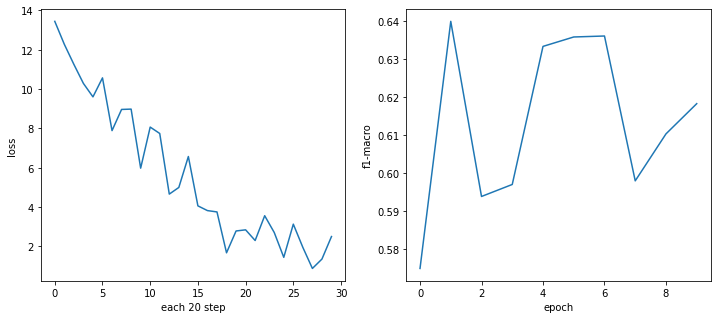

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(len(loss_collection)), loss_collection)
plt.xlabel(f'each {k} step')
plt.ylabel('loss')

plt.subplot(122)
plt.plot(range(len(eval_f1_macro)), eval_f1_macro)
plt.xlabel(f'epoch')
plt.ylabel('f1-macro')

## Tesing

In [17]:
# test dataloader
test_dataset = NewsDataloader(test_data, tokenizer)
batch_size = 11
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

with torch.no_grad():
  all_pred = []
  all_label = []
  for j, data in enumerate(test_dataloader):
    input_ids = data[0]["input_ids"].squeeze().to(device)
    attention_mask = data[0]["attention_mask"].squeeze().to(device)
    labels = data[1].to(device)
    feed_dict = {
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }
    output = best_model(feed_dict)
    pred = output.argmax(dim=1, keepdim=True)
    all_label.extend(list(labels.cpu().numpy()))
    all_pred.extend(list(pred.view(-1).cpu().numpy()))


  f1_macro = f1_score(all_label, all_pred, average='macro')
  f1_micro = f1_score(all_label, all_pred, average='micro')
  accuracy = accuracy_score(all_label, all_pred)
  recall = recall_score(all_label, all_pred)
  roc_auc = roc_auc_score(all_label, all_pred)
  precision = precision_score(all_label, all_pred)

  print(f'ROC-AUC {roc_auc}')
  print(f'F1-macro {f1_macro}')
  print(f'F1-micro {f1_micro}')
  print(f'Accuracy {accuracy}')
  print(f'Recall {recall}')
  print(f'Precision {precision}')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2257: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


ROC-AUC 0.6414728682170543
F1-macro 0.6005578169757274
F1-micro 0.7410832232496698
Accuracy 0.7410832232496698
Recall 0.5
Precision 0.2857142857142857


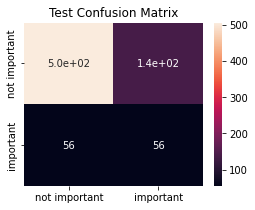

In [18]:
# confusion matrix for test data
classes = ['not important', 'important']
c_mat = confusion_matrix(all_label, all_pred)
df_cm = pd.DataFrame(c_mat, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (4,3))
plt.title('Test Confusion Matrix')
sn.heatmap(df_cm, annot=True)
plt.savefig('roberta_conf.jpg', dpi=400)

In [19]:
# save model
from google.colab import drive  
drive.mount('/content/drive')
torch.save(best_model, 'drive/MyDrive/project_roberta_kmeans.pth')

Mounted at /content/drive


# Load & Use Model

In [ ]:
best_model = torch.load('project_roberta_kmeans.pth')